<strong>Aluno</strong>: Victor São Paulo Ruela



In [40]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pylab import cm

plt.style.use('ggplot')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MLP para aproximação de funções

Neste trabalho é feita a implementação do algoritmo MLP com treinamento via back-propagation, e sua avaliação para a aproximação da função seno com ruído de medição uniforme.


In [55]:
Ntrain = 45
X = np.linspace(0, 2 * np.pi, Ntrain).reshape(-1,1)
y = np.sin(X) + np.random.uniform(-0.1,0.1, (len(X),1))

X_test = np.arange(0, 2 * np.pi, step=0.01).reshape(-1,1)
y_test = np.sin(X_test)

A seguir é feita a implementação do algoritmo MLP, usando como base as notas de aula. 

In [30]:
class MLP:
    def __init__(self, p, m, max_epochs=100, eta=0.01, tol=0.0001):
      self.p = p
      self.m = m
      self.eta = eta
      self.max_epochs = max_epochs
      self.tol = tol

    def sech2(self, u):
        return ((2/(np.exp(u)+np.exp(-u)))*(2/(np.exp(u)+np.exp(-u))))

    def fit(self, X, y):
        # augment X
        N, n = X.shape
        x_aug = np.hstack((np.ones((N, 1)), X))

        # initialize the weight and hidden layer matrixes
        w = np.random.uniform(-0.5, 0.5, (self.p+1, self.m))
        Z = np.random.uniform(-0.5, 0.5, (n+1, self.p))

        # initialize the main loop
        epochs = 0
        error_epoch = []
        ediff = np.Inf

        while((epochs < self.max_epochs)):
            xseq = np.arange(N)
            np.random.shuffle(xseq)
            ei2 = 0
            for iseq in xseq:  
                # current input/output pair
                xa = x_aug[iseq,:]
                ya = y[iseq]
                
                # hidden layer pass
                U = xa.T @ Z
                H = np.tanh(U)
                H_aug = np.hstack((1, H)) #np.hstack((np.ones((N, 1)), H))
                
                # output layer pass
                O = H_aug @ w
                y_hat = O # apply indentity activation function
                
                # propagate output error
                e = ya - y_hat
                dO = e # repeat the error beacuse dU_o = 1

                # propagate hidden layer error
                # the bias should not be considered
                ehidden = dO @ w[:-1,:].T
                dU = ehidden * self.sech2(U)

                # update w and Z
                w = w + self.eta * (H_aug.reshape(1,-1).T @ dO.reshape(1,-1))
                Z = Z + self.eta * (xa.reshape(-1,1) @ dU.reshape(1,-1))

                ei2 = ei2 + (e @ e.T)
            
            ei2 = ei2 / N
            error_epoch.append(ei2)
            epochs = epochs + 1
            
        self.coef_ = w
        self.Z_ = Z
        self.error_epoch_ = error_epoch

        return self

    def predict(self, X):
        N, _ = X.shape
        x_aug = np.hstack((np.ones((N, 1)), X))
        # forward pass through hidden layer
        H = np.tanh(x_aug @ self.Z_)
        # add bias and forward pass on output layer
        H_aug = np.hstack((np.ones((N, 1)), H))
        yhat = H_aug @ self.coef_
        return yhat

 Para se obter uma função de ativação linear na camada de saída, foi considerado somente um neurônio, de forma que o saída final da rede é a soma das saídas de cada neurônio da camada escondida ponderado pelo respectivo peso. 
 
O algoritmo de treinamento é então executado 5 vezes. As aproximações obtidas e o MSE médio e desvio padrão são exibidos na figura a seguir.

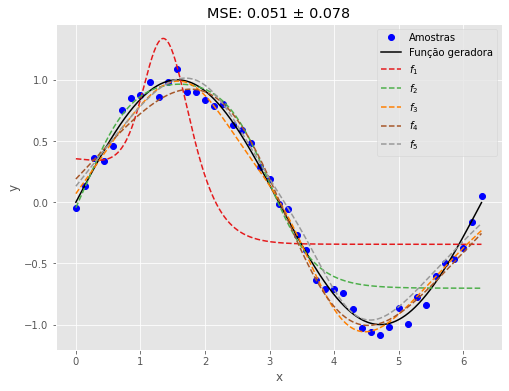

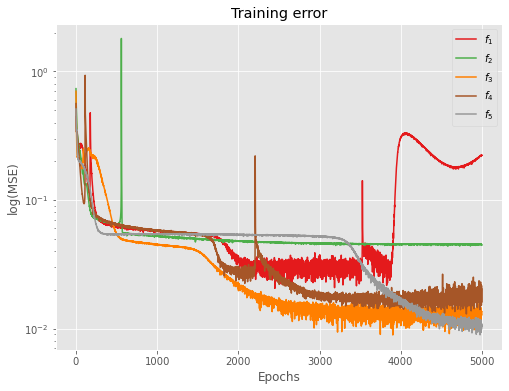

In [46]:
mse_array = []
max_epochs = 5000
n_hidden = 3
n_output = 1
learning_rate = 0.01

cmap = cm.get_cmap('Set1', 5)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(X, y, 'bo', label='Amostras')
ax.plot(X_test, y_test, 'k-', label='Função geradora')

fig_e, ax_e = plt.subplots(figsize=(8,6))
ax_e.set_xlabel('Epochs')
ax_e.set_ylabel('log(MSE)')
ax_e.set_title('Training error')
ax_e.set_yscale('log')

mlp = MLP(n_hidden, n_output, max_epochs, learning_rate)
for i in range(5):
    mlp = mlp.fit(X,y)
    y_hat = mlp.predict(X_test)
    mse_array.append(mean_squared_error(y_test, y_hat))
    
    ax.plot(X_test, y_hat, 'g--', label=f'$f_{i+1}$', color=cmap(i))
    ax_e.plot(np.arange(max_epochs), mlp.error_epoch_, label=f'$f_{i+1}$', color=cmap(i))

ax.set_title(f'MSE: {np.mean(mse_array):.3f} ± {np.std(mse_array):.3f}')
ax.legend()
fig.show()

ax_e.legend()
fig_e.show()

A partir dos resultados acima, podemos observar que o algoritmo back-propagation é bastante sensível à inicialização dos pesos e sequência dos padrões apresentadas à rede. Observou-se também que o aumento exagerado do número épocas de treinamento levava o algoritmo a não convergir dependendo da escolha de ponto inicial. Isso pode ser observado para a aproximação #1, para a qual o algoritmo sofreu um aumento abrupto do MSE com 4000 épocas de treinamento. Observe também que ocorrem alguns picos desse valor para outras aproximações, embora elas consigam atingir a convergência. Estas observações comprovam a característica não-convexa deste modelo de rede neural, uma vez que o back-propagation é uma abordagem baseada em gradientes. Isso sugere o uso de técnicas de otimização mais robustas para lidar com esse problema.

Vale a pena ressaltar que foi necessário um ajuste fino da quantidade máxima de épocas de treinamento e taxa de aprendizado. Valores baixos podem resultar em convergência prematura, conforme foi observado durante testes iniciais. Além disso, observa-se um pouco de underfitting para algumas das aproximações obtidas, conforme visto pelos gráficos. Isso sugere que para a escolha de pesos iniciais, o algoritmo back-propagation ficou preso em algum mínimo local. Isso fica claro para a função #4, uma vez a rede não consegue evoluir após cerca de 1000 épocas. As demais curvas foram capazes de aproximar com precisão a função geradora, mesmo utilizando somente 3 neurônios na camada escondida.